In [1]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes


import json
import torch
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from huggingface_hub import HfFolder, notebook_login
! pip install transformers[torch] -U
! pip install accelerate -U


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
from transformers import pipeline
from transformers import TextClassificationPipeline
# Load the tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model_finetuned_addition_ml_dataset",  model_max_length = 512)
model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model_finetuned_addition_ml_dataset")
#classifier = pipeline('text-classification',"/content/drive/MyDrive/Marcus_Project/removed_n/model")
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=1,
    truncation=True,  # Ensures that input sequences are truncated
    padding=True      # Pads sequences to the maximum length
)


In [4]:
with open("/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_chatgpt_train.jsonl", "r") as file:
    train_data = [json.loads(line) for line in file]

with open("/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_chatgpt_validation.jsonl", "r") as file:
    val_data = [json.loads(line) for line in file]



In [5]:
# Collect unique keys
unique_keys = set()
for json_obj in train_data:
    unique_keys.update(json_obj.keys())

    # Print unique keys
print("Keys in the JSONL file:", list(unique_keys))



Keys in the JSONL file: ['human_text', 'source', 'prompt', 'source_id', 'machine_text', 'model']


In [6]:
from datasets import Dataset

def prepare_dataset(data, abstract = "human_text", machine_abstract = "machine_text"):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})
    return dataset


In [7]:
# Prepare datasets
train_dataset = prepare_dataset(train_data, abstract = 'human_text', machine_abstract = 'machine_text')
validation_dataset = prepare_dataset(val_data, abstract = 'human_text', machine_abstract = 'machine_text')

In [8]:
print("Size of the train dataset:", len(train_dataset))
print("Size of the validation dataset:", len(validation_dataset))


Size of the train dataset: 3832
Size of the validation dataset: 960


In [9]:
# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length = 512)



In [10]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

In [11]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Marcus_Project/removed_n",
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Adjusted for potential GPU memory constraints
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_dir="/content/drive/MyDrive/Marcus_Project/removed_n",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to="tensorboard",
    push_to_hub=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [13]:
# Fine-tune the model
trainer.train()

evaluation_results = trainer.evaluate()
print(evaluation_results)



Epoch,Training Loss,Validation Loss
1,0.000100,0.005679
2,0.000000,0.007055
3,0.000000,0.007305


{'eval_loss': 0.0056785461492836475, 'eval_runtime': 34.9884, 'eval_samples_per_second': 27.438, 'eval_steps_per_second': 6.859, 'epoch': 3.0}


In [14]:
import os

# Define the directory in Google Drive where you want to save the model
output_dir = "/content/drive/MyDrive/Marcus_Project/removed_n"

# Make sure the directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the trained model and tokenizer
model_path = os.path.join(output_dir, "model_finetuned_addition_ml_wiki_dataset")
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


trainer.model.config.save_pretrained(model_path)



In [15]:
from transformers import pipeline
from transformers import TextClassificationPipeline
# Load the tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model_finetuned_addition_ml_wiki_dataset",  model_max_length = 512)
model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model_finetuned_addition_ml_wiki_dataset")
#classifier = pipeline('text-classification',"/content/drive/MyDrive/Marcus_Project/removed_n/model")
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=1,
    truncation=True,  # Ensures that input sequences are truncated
    padding=True      # Pads sequences to the maximum length
)


##Testing on Wiki gpt data

In [16]:
test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_chatgpt_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

In [17]:
wiki_gpt_test_data = prepare_dataset(test_data, abstract = 'human_text', machine_abstract = 'machine_text')
print("Size of the dataset:", len(wiki_gpt_test_data))


Size of the dataset: 1198


In [21]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

# Define classification function
def classify_text(example):
    try:
        predictions = classifier(example['text'])
        return {'predicted_labels': predictions[0][0]['label']}
    except Exception as e:
        #print(f"Error processing example: {example['text']}")
        print(e)
        return {'predicted_labels': None}



In [22]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
wiki_gpt_test_data = wiki_gpt_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/1198 [00:00<?, ? examples/s]

In [23]:
df_test_dataset_wiki_gpt = wiki_gpt_test_data.to_pandas()
df_test_dataset_wiki_gpt['target_labels'] = df_test_dataset_wiki_gpt['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [24]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_wiki_gpt['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_wiki_gpt = df_test_dataset_wiki_gpt.dropna(subset=['predicted_labels'])


In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Unique values in predicted_labels: {'machine-generated', 'human-produced'}
Unique values in true_labels: {'machine-generated', 'human-produced'}
Confusion Matrix in Percentage:
[[100.   0.]
 [  0. 100.]]


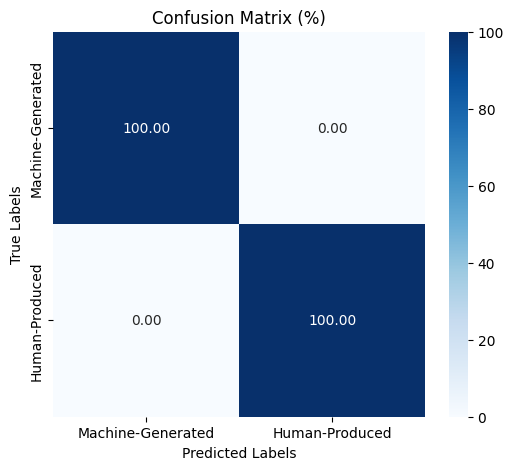

In [26]:
predicted_labels = df_test_dataset_wiki_gpt.predicted_labels.to_list()
true_labels = df_test_dataset_wiki_gpt.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


##Testing wiki coher dataset

In [27]:
import json

test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_cohere_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

# Collect unique keys
unique_keys = set()
for json_obj in test_data:
    unique_keys.update(json_obj.keys())

# Print unique keys
print("Keys in the JSONL file:", list(unique_keys))


Keys in the JSONL file: ['human_text', 'source', 'prompt', 'source_id', 'machine_text', 'model']


In [28]:
wiki_coher_test_data = prepare_dataset(test_data, abstract = 'human_text', machine_abstract = 'machine_text')
print("Size of the dataset:", len(wiki_coher_test_data))


Size of the dataset: 936


In [29]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
wiki_coher_test_data = wiki_coher_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/936 [00:00<?, ? examples/s]

In [30]:
df_test_dataset_wiki_coher = wiki_coher_test_data.to_pandas()
df_test_dataset_wiki_coher['target_labels'] = df_test_dataset_wiki_coher['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [31]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_wiki_coher['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_wiki_coher = df_test_dataset_wiki_coher.dropna(subset=['predicted_labels'])


Unique values in predicted_labels: {'machine-generated', 'human-produced'}
Unique values in true_labels: {'machine-generated', 'human-produced'}
Confusion Matrix in Percentage:
[[ 98.29059829   1.70940171]
 [  0.         100.        ]]


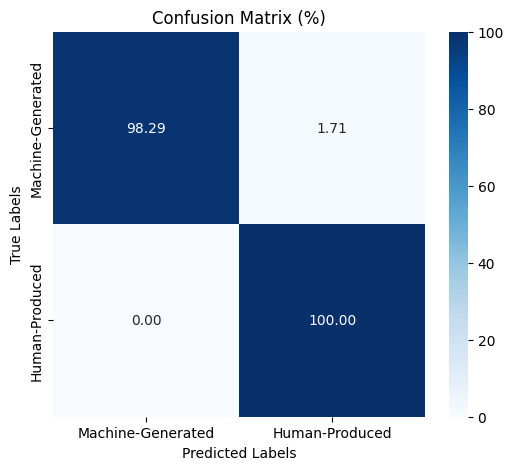

In [32]:
predicted_labels = df_test_dataset_wiki_coher.predicted_labels.to_list()
true_labels = df_test_dataset_wiki_coher.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


##Testing wiki davinci data

In [33]:
import json

test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_davinci_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

# Collect unique keys
unique_keys = set()
for json_obj in test_data:
    unique_keys.update(json_obj.keys())

# Print unique keys
print("Keys in the JSONL file:", list(unique_keys))


Keys in the JSONL file: ['human_text', 'source', 'prompt', 'source_id', 'machine_text', 'model']


In [34]:
wiki_davinci_test_data = prepare_dataset(test_data, abstract = 'human_text', machine_abstract = 'machine_text')
print("Size of the dataset:", len(wiki_davinci_test_data))


Size of the dataset: 1200


In [35]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
wiki_davinci_test_data = wiki_davinci_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [36]:
df_test_dataset_wiki_davinci = wiki_davinci_test_data.to_pandas()
df_test_dataset_wiki_davinci['target_labels'] = df_test_dataset_wiki_davinci['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [37]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_wiki_davinci['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_wiki_davinci = df_test_dataset_wiki_davinci.dropna(subset=['predicted_labels'])


Unique values in predicted_labels: {'machine-generated', 'human-produced'}
Unique values in true_labels: {'machine-generated', 'human-produced'}
Confusion Matrix in Percentage:
[[ 99.16666667   0.83333333]
 [  0.         100.        ]]


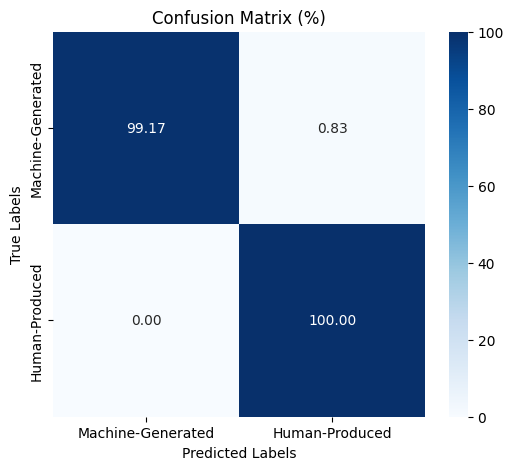

In [38]:
predicted_labels = df_test_dataset_wiki_davinci.predicted_labels.to_list()
true_labels = df_test_dataset_wiki_davinci.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


##Tetsing Wiki bloomz dataset

In [39]:
import json

test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_bloomz_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

# Collect unique keys
unique_keys = set()
for json_obj in test_data:
    unique_keys.update(json_obj.keys())

# Print unique keys
print("Keys in the JSONL file:", list(unique_keys))


Keys in the JSONL file: ['id', 'probas', 'url', 'title', 'source', 'logits', 'prompt', 'text', 'score', 'machine_text', 'model', 'machine_abstract']


In [41]:
wiki_bloomz_test_data = prepare_dataset(test_data, abstract = 'text', machine_abstract = 'machine_text')
print("Size of the dataset:", len(wiki_bloomz_test_data))


Size of the dataset: 1200


In [42]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
wiki_bloomz_test_data = wiki_bloomz_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [43]:
df_test_dataset_wiki_bloomz = wiki_bloomz_test_data.to_pandas()
df_test_dataset_wiki_bloomz['target_labels'] = df_test_dataset_wiki_bloomz['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [44]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_wiki_bloomz['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_wiki_bloomz = df_test_dataset_wiki_bloomz.dropna(subset=['predicted_labels'])


Unique values in predicted_labels: {'machine-generated', 'human-produced'}
Unique values in true_labels: {'machine-generated', 'human-produced'}
Confusion Matrix in Percentage:
[[63.33333333 36.66666667]
 [ 0.5        99.5       ]]


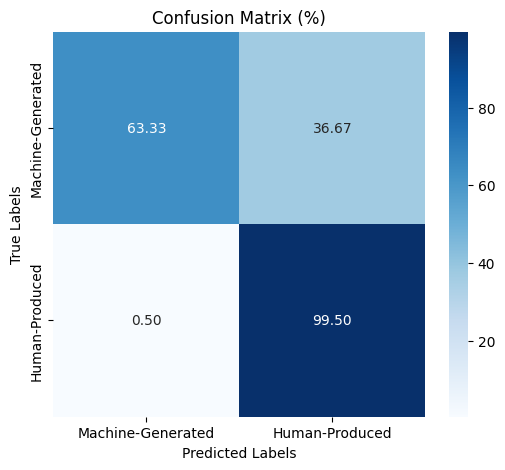

In [45]:
predicted_labels = df_test_dataset_wiki_bloomz.predicted_labels.to_list()
true_labels = df_test_dataset_wiki_bloomz.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()
